<img src = "../../Data/bgsedsc_0.jpg">

In [63]:
## Set up ----
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

import random
import time
import scipy
import datetime
import pandas as pd
import numpy as np
import sklearn
import pandas as pd
import numpy as np
import time

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler, OneHotEncoder,  scale
import category_encoders as ce
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# kernel approximators
from sklearn.kernel_approximation import Nystroem, RBFSampler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import gc
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# Random state
rand_state = 1111
np.random.seed(rand_state) # impose random seed for reproducibility

# Some base models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble, TemporalEnsemble

# Training dataset
data=pd.read_csv('../Data/mimic_train.csv')
data_test=pd.read_csv('../Data/mimic_test_los.csv')

# Ensembles

This notebook continues on from the related [notebook](2_decision-trees.ipynb) on decision trees - the main notebook. In this notebook we just ensemble different regression methods to see if we can arraive at improved predictions. Unsurprisingly computations here are even more expensive than the grid search in the previous notebook. 

## 1) Pre-processing

As discussed in the notebook on decision trees, all preprocessing has been moved into a separate [notebook](1_preproc.ipynb). To run the preprocessing from here simply uncomment and run the below:

In [64]:
#%run ./preproc.ipynb

In [65]:
# Read pre-processed data:
y = data.loc[:,'LOS']
X = pd.read_csv("../Data/los/X_preproc.csv")
X_test = pd.read_csv("../Data/los/X_test_preproc.csv")
data = pd.concat([y,X], axis=1)

In [66]:
# Check:
print(X.shape)
print(X_test.shape)
print(y.shape)

(20885, 44)
(5221, 44)
(20885,)


In [67]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test ,y_train, y_test = train_test_split(
    np.array(X),
    y, 
    test_size=0.7, random_state=rand_state
)

target_name = 'LOS'
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## 2) Prediction

I use a set of basic models including XGBoost. For the latter I use whatever parameter values yielded optimal results for standalone prediction in the decision tree notebook.

In [68]:
def get_models():
    #Generate a library of simple learners
    svr = SVR(C=100)
    knn = KNeighborsRegressor(n_neighbors=3)
    rf = RandomForestRegressor(n_estimators=10, max_features=3, random_state=rand_state)
    lr = LinearRegression()
    xgb = XGBRegressor(
        learning_rate=0.01, 
        objective='reg:squarederror', 
        n_estimators=100, 
        subsample=0.5, 
        max_depth=6
    )
    models = {
        'svm': svr,
        'knn': knn,
        'random forest': rf,
        'linear reg': lr,
        'xgb': xgb      
    }
    return models

def train_predict(model_list,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):

    if y_test is None:
        P = np.zeros((X_test.shape[0], len(model_list)))
        P = pd.DataFrame(P)
    else:
        P = np.zeros((y_test.shape[0], len(model_list)))
        P = pd.DataFrame(P)

    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train)
        P.iloc[:, i] = m.predict(X_test)
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    # Score model in test set
    print("Scoring models.")
    scores=[]
    for m in P.columns:
        score = np.sqrt(mean_squared_error(y, P.loc[:, m]))
        scores.append(score)
        print("%-26s: %.3f" % (m, score))
    return P.columns,scores

First let us look at the correlations between the different model predictions.

knn... done
random forest... done
linear reg... done
xgb... done
Done.

Scoring models.
knn                       : 5.321
random forest             : 5.032
linear reg                : 4.632
xgb                       : 4.890


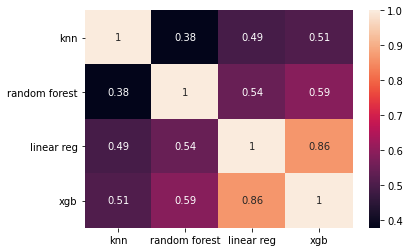

In [69]:
models = get_models()
P = train_predict(models,X_train,y_train,X_test,y_test)
my_models,my_scores= score_models(P, y_test)
#Plot correlations
sns.heatmap(P.corr(), annot=True)
plt.show()

Initialize a `results` list to store the accuracy scores:

In [70]:
# Save results
results=[(model,score) for model,score in zip(my_models,my_scores)]
results

[('knn', 5.321037419012124),
 ('random forest', 5.0321203307031555),
 ('linear reg', 4.632310749105949),
 ('xgb', 4.890404705596846)]

### 2.1) Averaging

We will begin by simply averaging the predictions and add the resulting score to the results. We actually get quite a bit of improvement here, likely due to the fact that KNN predictions are so different from the others.

In [71]:
# Simple average
AvgPred=pd.DataFrame(P.mean(axis=1),columns=['Avg'])
my_model_avg,my_scores_avg= score_models(AvgPred, y_test)

Scoring models.
Avg                       : 4.716


In [72]:
# Save results
results=results+[(model,score) for model,score in zip(my_model_avg,my_scores_avg)]

### 2.2) Stacking

Stacking does not lead to much improvement:

In [73]:
#meta_learner = ExtraTreesRegressor(
#    n_estimators=20,
#    bootstrap=True,
#    max_features=0.7
#)
#
## Instantiate the ensemble with 5 folds (stacking meta-learner)
#sl = SuperLearner(
#    folds=5,
#    verbose=2,
#    backend="multiprocessing",
#    n_jobs=3
#)
#
## Add the base learners and the meta learner
#sl.add(list(models.values()))
#sl.add_meta(meta_learner)
#
## Train the ensemble
#sl.fit(X_train, y_train)
#
## Predict the test set
#p_sl = sl.predict(X_test)
#scoreStackXtres=mean_squared_error(y_test, p_sl[:, 1])
#print("\nSuper Learner ROC-AUC score: %.3f" % scoreStackXtres)

In [74]:
## Save results
#results=results+[('StackingExtraTrees',scoreStackXtres)]
#results

### 2.3) Feature propagation

Let's try to propagate the most important features (as per the random forest model):

In [75]:
#n_features = 5
#rf_features = models['rf'].feature_importances_
#rf_features_ordered = pd.Series(data=rf_features, index=range(len(rf_features))).sort_values(ascending=False)
#to_propagate = list(rf_features_ordered[:n_features].index)
#pointer = to_propagate

Evidently this leads to improvement with stacking:

In [76]:
#sl2 = SuperLearner(
#    folds=5,
#    random_state=rand_state,
#    verbose=2,
#    backend="multiprocessing",
#    n_jobs=3
#)
#
## Add the base learners and the meta learner
#sl2.add(list(models.values()), proba=True, propagate_features=pointer)
#sl2.add_meta(meta_learner, proba=True)
#
## Train the ensemble
#sl2.fit(X_train, y_train)
#
## Predict the test set
#p_sl2 = sl2.predict_proba(X_test)
#scoreStackXtres2=mean_squared_error(y_test, p_sl2[:, 1])
#print("\nSuper Learner 2 ROC-AUC score: %.3f" % scoreStackXtres2)

In [77]:
## Save results
#results=results+[('StackingExtraTrees2',scoreStackXtres2)]
#results

### 2.4) Blending

In [78]:
#bl =  BlendEnsemble(test_size=0.2, random_state=rand_state,n_jobs=3)
#
## Add the base learners and the meta learner
#bl.add(list(models.values()), proba=True, propagate_features=pointer)
#bl.add_meta(meta_learner, proba=True)
#
## Train the ensemble
#bl.fit(X_train, y_train)
#
## Predict the test set
#p_bl = bl.predict_proba(X_test)
#scoreBlendXtrees=mean_squared_error(y_test, p_bl[:, 1])
#print("\nBlend ROC-AUC score: %.3f" % scoreBlendXtrees)

In [79]:
## Save results
#results=results+[('BlendXtrees',scoreBlendXtrees)]
#results

### 2.5) Subsemple

In [80]:
#from sklearn.cluster import KMeans
#sub = Subsemble(partitions=3, folds=4,partition_estimator=KMeans(3, random_state=rand_state),
#               random_state=rand_state)
#
#sub.add(list(models.values()), proba=True, propagate_features=pointer)
#sub.add_meta(meta_learner, proba=True)
#
## Train the ensemble
#sub.fit(X_train, y_train)
#
## Predict the test set
#p_sub = sub.predict_proba(X_test)
#scoreSubS=mean_squared_error(y_test, p_sub[:, 1])
#print("\nSubSamble ROC-AUC score: %.3f" % scoreSubS)

In [81]:
## Save results
#results=results+[('SubSambleXtrees',scoreSubS)]
#results

### 2.6) Multi-layer

Let's define a second meta learner and run a multi-layer ensemble:

In [82]:
#meta_learner_2 = RandomForestClassifier(n_estimators=10, max_features=3, random_state=rand_state)

In [83]:
#ensemble = SequentialEnsemble(random_state=rand_state)
#
## The initial layer is a blended layer, same as a layer in the BlendEnsemble
#ensemble.add('blend',
#             list(models.values()), proba=True, propagate_features=pointer,random_state=rand_state)
#
## The second layer is a stacked layer, same as a layer of the SuperLearner
#ensemble.add('stack', [meta_learner, meta_learner_2], proba=True,random_state=rand_state)
#
## The third layer is a subsembled layer, same as a layer of the Subsemble
#ensemble.add('subsemble', [meta_learner, meta_learner_2], proba=True,random_state=rand_state)
#
## The meta estimator is added as in any other ensemble
#ensemble.add_meta(LogisticRegression(), proba=True)
## Train the ensemble
#ensemble.fit(X_train, y_train)
#
## Predict the test set
#p_multi = ensemble.predict_proba(X_test)
#scoreMultiE=mean_squared_error(y_test, p_multi[:, 1])
#print("\nMulti-Ensemble ROC-AUC score: %.3f" % scoreMultiE)

In [84]:
## Save results
#results=results+[('Multi-Layer',scoreMultiE)]
#results

## 3) Model evaluation with test set



In [85]:
#results_df=pd.DataFrame(results)
#results_df.columns=['Method','AUC_score']
#results_df= results_df.sort_values(by='AUC_score', ascending=False)
#results_df.head()

In [86]:
#import seaborn as sns
#import matplotlib.pyplot as plt
#
#sns.set(style="whitegrid")
#ax = sns.barplot(x="Method", y="AUC_score", data=results_df)
#ax= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#
#plt.ylim(0.65,0.75)

## 4) Final prediction and export

Finally, we can use the full training sample to fit the model and then predict from the test sample.

In [87]:
y = data.loc[:,'LOS']
X = pd.read_csv("../Data/los/X_preproc.csv")
X_test = pd.read_csv("../Data/los/X_test_preproc.csv")
y_hat_all = train_predict(models,X,y,X_test,y_test=None)
y_hat=pd.DataFrame(y_hat_all.mean(axis=1),columns=['Avg'])
cols,final_score= score_models(AvgPred, y_test)

knn... done
random forest... done
linear reg... done
xgb... done
Done.

Scoring models.
Avg                       : 4.716


In [88]:
chosen_ensemble = 'Avg'
data_test=pd.read_csv('../Data/mimic_test_death.csv')
predictions = pd.DataFrame({'icustay_id': data_test.icustay_id.values, 'LOS': y_hat.Avg})
output_name = f"output/ensmbl_predictions_score:{final_score[0]}" 
predictions.to_csv(output_name, index=False)
predictions.describe()

,icustay_id,LOS
count,5221.000000,5221.000000
mean,249925.293239,3.456036
std,28763.030681,2.028453
min,200011.000000,-0.425333
25%,225118.000000,2.227413
50%,249759.000000,3.026991
75%,274576.000000,4.272136
max,299979.000000,77.695550
